In [1]:
import tensorflow as tf
from tensorflow import keras
import cv2
import albumentations as A
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

%matplotlib inline
pd.set_option("display.max_rows",None)

In [3]:
pth = Path("../Datasets/dogs_vs_cats/idx_labels_.csv")
df = pd.read_csv(pth)
df.head()

,id,target
0,../Datasets/dogs_vs_cats/train/dog.8011.jpg,dog
1,../Datasets/dogs_vs_cats/train/cat.5077.jpg,cat
2,../Datasets/dogs_vs_cats/train/dog.7322.jpg,dog
3,../Datasets/dogs_vs_cats/train/cat.2718.jpg,cat
4,../Datasets/dogs_vs_cats/train/cat.10151.jpg,cat


In [4]:
df["label"] = LabelEncoder().fit_transform(df.target.values)
df.head()

,id,target,label
0,../Datasets/dogs_vs_cats/train/dog.8011.jpg,dog,1
1,../Datasets/dogs_vs_cats/train/cat.5077.jpg,cat,0
2,../Datasets/dogs_vs_cats/train/dog.7322.jpg,dog,1
3,../Datasets/dogs_vs_cats/train/cat.2718.jpg,cat,0
4,../Datasets/dogs_vs_cats/train/cat.10151.jpg,cat,0


In [5]:
class Generator(keras.utils.Sequence):
    def __init__(self, df:pd.DataFrame, tfms:Callable=None, bs:int=1)->None:
        self.bs = bs
        self.df = df
        self.tfms = tfms
        
    def __len__(self)->int:
        return len(self.df)//self.bs
    
    def __get_data(self, batch_ids)->tuple:
        x, y = [], []
        # generate images and labels
        for idx in batch_ids:
            im = cv2.cvtColor(cv2.imread(self.df["id"][idx]), cv2.COLOR_BGR2RGB)
            lbl = self.df["label"][idx]
            if self.tfms is not None:  im = self.tfms(image=im)["image"]
            x.append(im)
            y.append(lbl)
        return np.array(x), np.array(y)
             
    def __getitem__(self, idx)->tuple:
        i = idx * self.bs
        batch_ids = np.arange(i, i + self.bs, 1)
        x, y = self.__get_data(batch_ids)
        return x, y

In [6]:
H = 128  # heigth
W = 128  # width

In [7]:
def get_tfms(trn:bool=False)->A.Compose:    
    tfms = [
        A.HorizontalFlip(),
        A.Rotate(limit=50),
        A.IAASharpen(p=0.5)
    ]
    
    norms = [A.Resize(H,W, always_apply=True)]
    if trn: T = A.Compose(tfms+norms)
    else   : T = A.Compose(norms)
    return T

In [8]:
trn_tfms=get_tfms(trn=True); val_tfms=get_tfms()

In [9]:
df = df.sample(frac=1).reset_index(drop=True)  # shuffle
df_trn, df_val = train_test_split(df, stratify=df.target)

df_trn.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

In [10]:
df_trn.head(5)

,id,target,label
0,../Datasets/dogs_vs_cats/train/dog.9673.jpg,dog,1
1,../Datasets/dogs_vs_cats/train/dog.1882.jpg,dog,1
2,../Datasets/dogs_vs_cats/train/cat.11522.jpg,cat,0
3,../Datasets/dogs_vs_cats/train/cat.5749.jpg,cat,0
4,../Datasets/dogs_vs_cats/train/cat.741.jpg,cat,0


In [11]:
df_val.head(5)

,id,target,label
0,../Datasets/dogs_vs_cats/train/dog.1703.jpg,dog,1
1,../Datasets/dogs_vs_cats/train/cat.8930.jpg,cat,0
2,../Datasets/dogs_vs_cats/train/dog.6882.jpg,dog,1
3,../Datasets/dogs_vs_cats/train/dog.5685.jpg,dog,1
4,../Datasets/dogs_vs_cats/train/cat.1347.jpg,cat,0


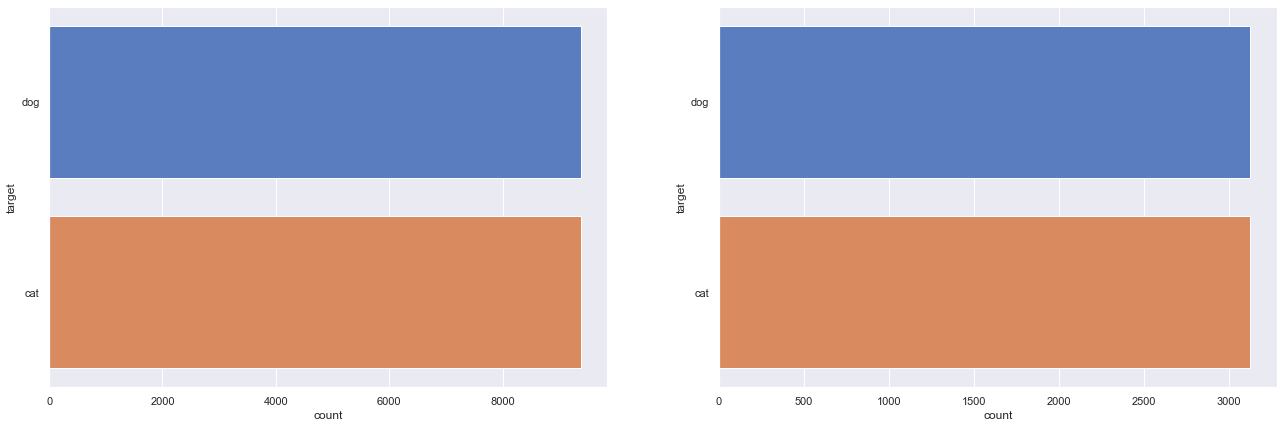

In [12]:
sns.set()
sns.set_palette("muted")

_ , (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 7))
sns.countplot(y=df_trn.target, ax=ax1)
sns.countplot(y=df_val.target, ax=ax2)

In [13]:
trn_ds = Generator(df_trn, tfms=trn_tfms, bs=64)
val_ds = Generator(df_val, tfms=val_tfms, bs=64)

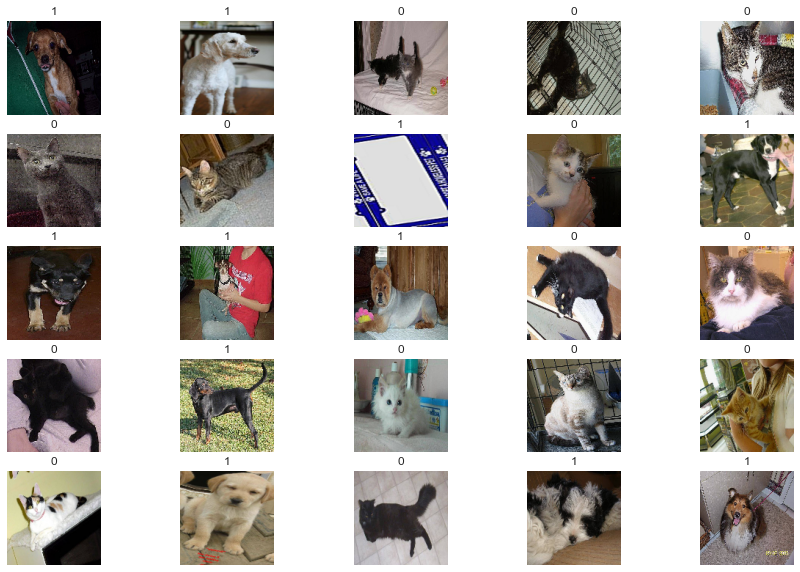

In [14]:
batch = next(iter(trn_ds))
ims, labels = batch

fig = plt.figure(figsize=(15, 10))

for n in range(25):
    ax = fig.add_subplot(5, 5, n+1, xticks=[])
    plt.imshow(ims[n])
    plt.title(labels[n])
    plt.axis("off")

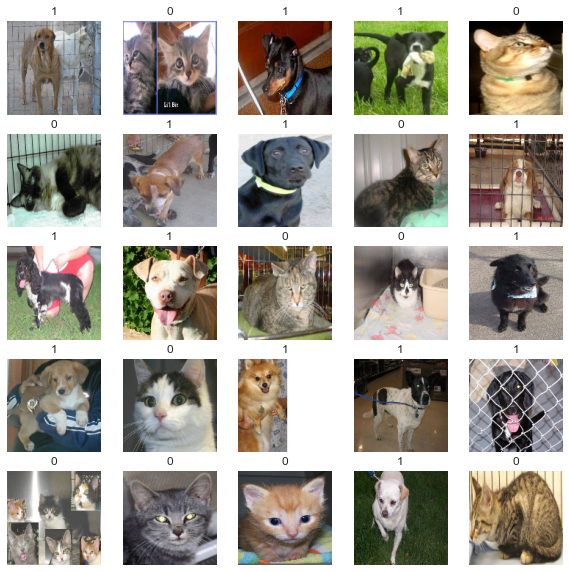

In [15]:
batch = next(iter(val_ds))
ims, labels = batch

fig = plt.figure(figsize=(10, 10))

for n in range(25):
    ax = fig.add_subplot(5, 5, n+1, xticks=[])
    plt.imshow(ims[n])
    plt.title(labels[n])
    plt.axis("off")

In [16]:
base_model = keras.applications.MobileNetV2(input_shape=[H,W,3],
                                                include_top=False, 
                                                pooling="max", 
                                                weights="imagenet")
base_model.trainable = False

In [17]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [18]:
def get_model(**kwargs)->keras.Model:
    # returns model
    inputs = keras.Input(shape=[H,W,3], name="input_layer")
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = keras.layers.Dropout(0.25, name="drop_0")(x)
    x = keras.layers.Dense(256, name="dense_1")(x)
    x = keras.layers.BatchNormalization(name="bnorm_1")(x)
    x = keras.layers.Activation("relu", name="relu_1")(x)
    x = keras.layers.Dropout(0.5, name="drop_1")(x)
    x = keras.layers.Dense(1, name="classifier")(x)
    x = keras.layers.Activation("sigmoid", name="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=x, **kwargs)
    return model

In [19]:
model = get_model(); model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 128, 128, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_128 (Model) (None, 1280)              2257984   
_________________________________________________________________
drop_0 (Dropout)             (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               327936    
_________________________________________________________________
bnorm_1 (BatchNormalization) (None, 256)               1024  

In [55]:
from one_cycle import OneCycleLr
from lr_find import LrFinder

In [22]:
optimizer = keras.optimizers.SGD(momentum=0.9)
loss_fn = keras.losses.BinaryCrossentropy()


LR Finder is complete, type {LrFinder}.plot_lrs() to see the graph.


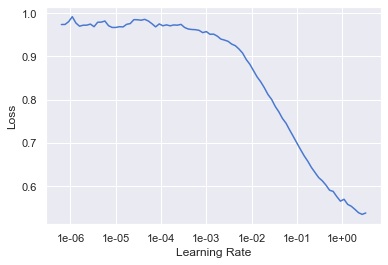

In [23]:
lr_find = LrFinder(model, optimizer, loss_fn)
lr_find.range_test(trn_ds)
lr_find.plot_lrs()

Min numerical gradient: 6.92E-02
Min loss divided by 10: 2.75E-01


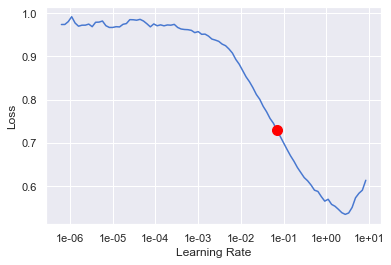

In [27]:
lr_find.plot_lrs(skip_end=0, suggestion=True)

In [28]:
max_lr = 5e-02
epochs = 5

one_c = OneCycleLr(max_lr=max_lr, steps_per_epoch=len(trn_ds), epochs=epochs)
cbs = [one_c]

optim = keras.optimizers.SGD(momentum=0.9, clipvalue=0.1)
model.compile(optimizer=optim, loss=loss_fn, metrics=["acc"])

h = model.fit(trn_ds, validation_data=val_ds, epochs=epochs, callbacks=cbs, workers=2)

Epoch 1/5
292/292 [==============================] - 171s 587ms/step - loss: 0.1770 - acc: 0.9227 - val_loss: 0.0674 - val_acc: 0.9734
Epoch 2/5
292/292 [==============================] - 173s 593ms/step - loss: 0.1165 - acc: 0.9523 - val_loss: 0.0647 - val_acc: 0.9757
Epoch 3/5
292/292 [==============================] - 175s 601ms/step - loss: 0.1092 - acc: 0.9559 - val_loss: 0.0607 - val_acc: 0.9758
Epoch 4/5
292/292 [==============================] - 173s 594ms/step - loss: 0.1015 - acc: 0.9590 - val_loss: 0.0538 - val_acc: 0.9786
Epoch 5/5
292/292 [==============================] - 188s 645ms/step - loss: 0.0967 - acc: 0.9605 - val_loss: 0.0538 - val_acc: 0.9781


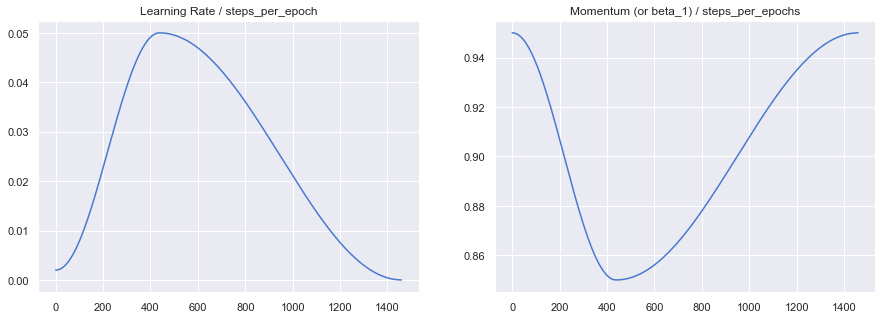

In [29]:
one_c.plot_lrs_moms()

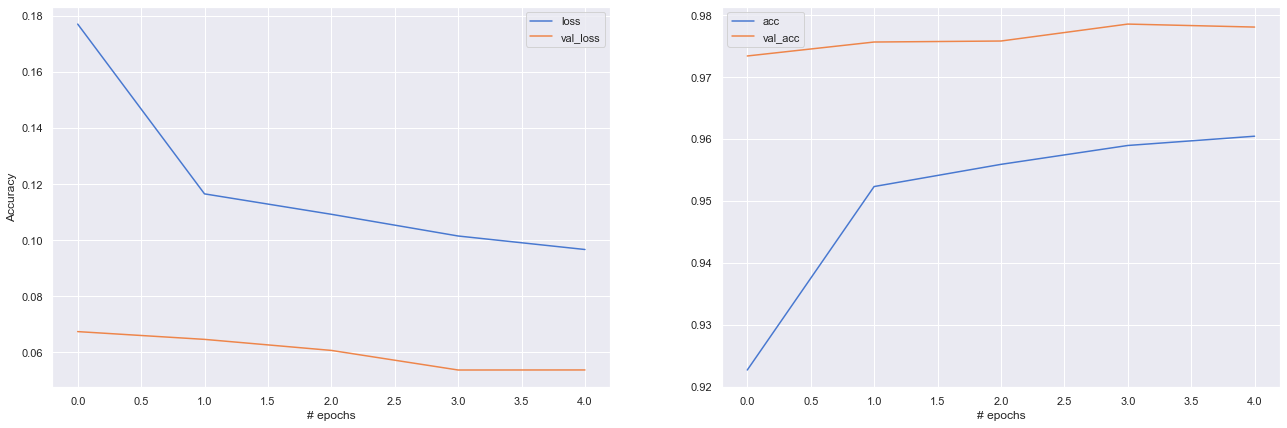

In [39]:
# plot the losses and accuracies
_ ,  (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 7))
ax1.plot(h.history["loss"], label="loss")
ax1.set_ylabel("Loss")
ax1.set_xlabel("# epochs")
ax1.plot(h.history["val_loss"], label="val_loss")
ax2.plot(h.history["acc"], label="acc")
ax2.plot(h.history["val_acc"], label="val_acc")
ax1.set_ylabel("Accuracy")
ax2.set_xlabel("# epochs")
ax1.legend(); ax2.legend();

### **`Finetuning`** : 

In [40]:
base_model.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 128, 128, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_128 (Model) (None, 1280)              2257984   
_________________________________________________________________
drop_0 (Dropout)             (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               327936    
_________________________________________________________________
bnorm_1 (BatchNormalization) (None, 256)               1024  

In [41]:
optim = keras.optimizers.SGD(momentum=0.9)

lr_finder = LrFinder(model, optim, loss_fn)
lr_finder.range_test(trn_ds)


LR Finder is complete, type {LrFinder}.plot_lrs() to see the graph.


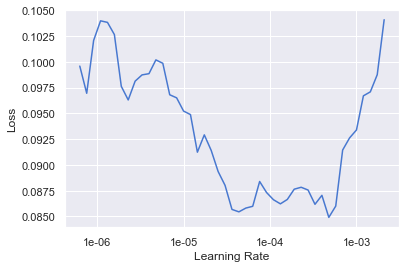

In [43]:
lr_finder.plot_lrs();

In [56]:
max_lr = 8e-06
epochs = 3

one_c = OneCycleLr(max_lr=max_lr, steps_per_epoch=len(trn_ds), epochs=epochs)
cbs = [one_c]

optim = keras.optimizers.SGD(momentum=0.9, clipvalue=0.1)
model.compile(optimizer=optim, loss=loss_fn, metrics=["acc"])

h2 = model.fit(trn_ds, validation_data=val_ds, epochs=epochs, callbacks=cbs)

Epoch 1/3
292/292 [==============================] - 430s 1s/step - loss: 0.0966 - acc: 0.9605 - val_loss: 0.0506 - val_acc: 0.9794
Epoch 2/3
292/292 [==============================] - 438s 1s/step - loss: 0.0824 - acc: 0.9673 - val_loss: 0.0492 - val_acc: 0.9802
Epoch 3/3
292/292 [==============================] - 429s 1s/step - loss: 0.0872 - acc: 0.9659 - val_loss: 0.0487 - val_acc: 0.9802


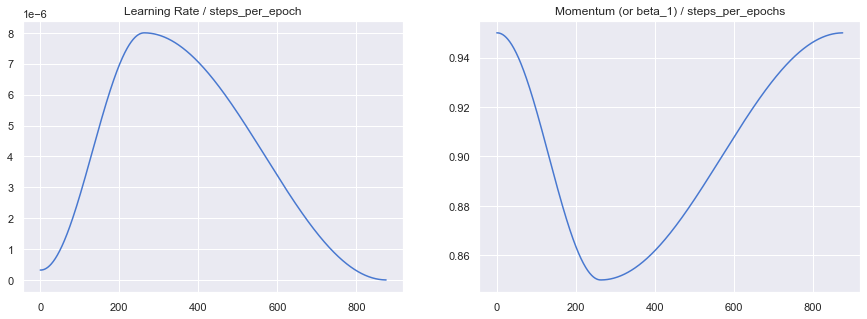

In [57]:
one_c.plot_lrs_moms()